### Overview
In this approach, the data from previous petfinder adoption (PET1) and current competition (PET2) is integrated. 
> Part 1: Image Models Training
In this part, multiple pretrained image models like EfficientNet and ConvNext are trained on PET2 (Current competition) images. Metadata is also added into the model. Initially, only PET2 images are used to generate Out-Of-Fold (OOF) predictions.

> Part 2: Pseudo-Labeling and Fine-Tuning
After stage 1, predictions are generated for PET1 (previous competition data) and treated as pseudo-labels. The PET2 models are retrained using both PET2 data and pseudo-labeled PET1 data.


### Reason for Good Performance

- Diverse Image Models: Using multiple pretrained models captures different features from pet images.

- Pseudo-Labeling: Allows the model to learn from PET1 data without label leakage, effectively increasing training data.


Overall, this combination of image models + pseudo-labels + metadata boosting + ensembling leads to a strong, stable prediction pipeline for the Petfinder Pawpularity task.

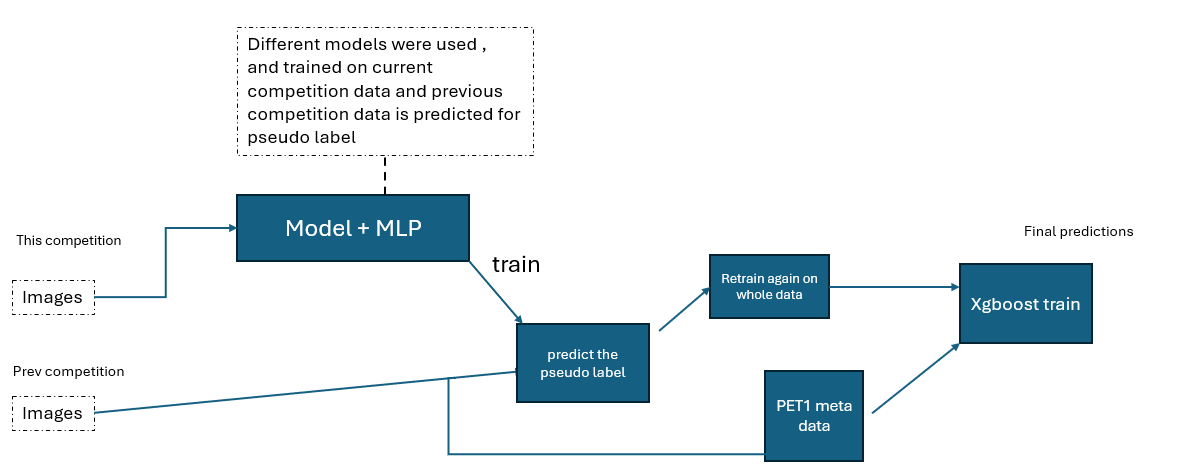

In [ ]:


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm
import albumentations as A
from tqdm.auto import tqdm
tqdm.pandas()
import os
import gc
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import imagehash
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_FOLDS = 5
SAVE_DIR = "top4"
os.makedirs(SAVE_DIR, exist_ok=True)



# DATA LOADING

BASE_PATH = "inputs/"
# Pet2 : Current competition data
train = pd.read_csv(f'{BASE_PATH}train.csv')
test = pd.read_csv(f'{BASE_PATH}test.csv')
train['file'] = train['Id'].map(lambda x: f'{BASE_PATH}train/{x}.jpg')
test['file'] = test['Id'].map(lambda x: f'{BASE_PATH}test/{x}.jpg')

metadata_cols = ['Subject Focus','Eyes','Face','Near','Action','Accessory',
                 'Group','Collage','Human','Occlusion','Info','Blur']
METADATA_DIM = len(metadata_cols)
train['metadata'] = train[metadata_cols].values.tolist()
test['metadata'] = test[metadata_cols].values.tolist()

prev_train_dir = f'{BASE_PATH}pet_adopt/train_images/'
prev_test_dir = f'{BASE_PATH}pet_adopt/test_images/'



# Pet1 (previous competition Pet Adoption)
prev_train = pd.read_csv(f'{BASE_PATH}pet_adopt/train/train.csv')
prev_test = pd.read_csv(f'{BASE_PATH}pet_adopt/test/test.csv')
prev_train['file'] = prev_train['PetID'].map(lambda x: f"{prev_train_dir}/{x}-1.jpg")
prev_test['file'] = prev_test['PetID'].map(lambda x: f"{prev_test_dir}/{x}-1.jpg")

prev_train = prev_train[prev_train['file'].map(os.path.exists)].reset_index(drop=True)
prev_test = prev_test[prev_test['file'].map(os.path.exists)].reset_index(drop=True)


train['fold'] = -1
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(train, train['Pawpularity'])):
    train.loc[val_idx, 'fold'] = fold


In [ ]:

# PART 1: HASH to Find the similar images in previous and this competition

print("\n" + "="*80)
print("HASHING AND MATCHING")
print("="*80)

def compute_hash(path):
    try:
        return str(imagehash.average_hash(Image.open(path).convert('RGB')))
    except:
        return None

print("Hashing pet2 train...")
train['hash'] = train['file'].progress_apply(compute_hash)
print("Hashing pet2 test...")
test['hash'] = test['file'].progress_apply(compute_hash)
print("Hashing pet1 train...")
prev_train['hash'] = prev_train['file'].progress_apply(compute_hash)
print("Hashing pet1 test...")
prev_test['hash'] = prev_test['file'].progress_apply(compute_hash)

# duplicates within pet2 train
hash_counts = train['hash'].value_counts()
dup_hashes = hash_counts[hash_counts > 1].index.tolist()
print(f"Found {len(dup_hashes)} duplicate hash groups")

#  duplicate groups
train['dup_group'] = -1
for i, h in enumerate(dup_hashes):
    train.loc[train['hash'] == h, 'dup_group'] = i

# Create folds ensuring duplicates stay together
train['fold'] = -1
train['strat_key'] = pd.cut(train['Pawpularity'], bins=10, labels=False)
unique_idx = train[train['dup_group'] == -1].index.tolist()

skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)
for fold, (_, val_idx) in enumerate(skf.split(unique_idx, train.loc[unique_idx, 'strat_key'])):
    train.loc[np.array(unique_idx)[val_idx], 'fold'] = fold

# Assign folds to duplicate groups
for group_id in range(len(dup_hashes)):
    group_idx = train[train['dup_group'] == group_id].index.tolist()
    if len(group_idx) > 0:
        fold = train.loc[group_idx[0], 'fold']
        if fold == -1:
            fold = np.random.randint(0, N_FOLDS)
        train.loc[group_idx, 'fold'] = fold

print("Fold distribution:")
print(train['fold'].value_counts().sort_index())

# Match with pet1
pet2_hashes = set(train['hash'].dropna())
pet1_train_hashes = set(prev_train['hash'].dropna())
pet1_test_hashes = set(prev_test['hash'].dropna())

matched_train = pet2_hashes & pet1_train_hashes
matched_test = pet2_hashes & pet1_test_hashes

train['in_pet1_train'] = train['hash'].isin(matched_train).astype(int)
train['in_pet1_test'] = train['hash'].isin(matched_test).astype(int)
train['in_pet1'] = (train['in_pet1_train'] | train['in_pet1_test']).astype(int)

print(f"Matched with pet1_train: {len(matched_train)}")
print(f"Matched with pet1_test: {len(matched_test)}")

# Clean pet1 data (remove overlaps)
prev_train_clean = prev_train[~prev_train['hash'].isin(pet2_hashes)].reset_index(drop=True)
prev_test_clean = prev_test[~prev_test['hash'].isin(pet2_hashes)].reset_index(drop=True)

print(f"Pet1 train clean: {len(prev_train_clean)}")
print(f"Pet1 test clean: {len(prev_test_clean)}")



HASHING AND MATCHING
Hashing pet2 train...


  0%|          | 0/9912 [00:00<?, ?it/s]

Hashing pet2 test...


  0%|          | 0/8 [00:00<?, ?it/s]

Hashing pet1 train...


  0%|          | 0/2020 [00:00<?, ?it/s]

Hashing pet1 test...


  0%|          | 0/2154 [00:00<?, ?it/s]

Found 25 duplicate hash groups
Fold distribution:
fold
0    1988
1    1976
2    1992
3    1980
4    1976
Name: count, dtype: int64
Matched with pet1_train: 217
Matched with pet1_test: 220
Pet1 train clean: 1803
Pet1 test clean: 1934


In [ ]:

# PART 2: DATASET AND MODEL


class PetDataset(Dataset):
    def __init__(self, paths, targets, metadata, transform=None):
        self.paths = paths
        self.targets = targets
        self.metadata = metadata
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.paths[idx]).convert('RGB'))
        h, w = img.shape[:2]
        if h > w:
            img = img[(h-w)//2:(h-w)//2+w, :]
        elif w > h:
            img = img[:, (w-h)//2:(w-h)//2+h]
        
        if self.transform:
            img = self.transform(image=img)["image"]
        
        img = np.transpose(img / 255.0, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(img, dtype=torch.float),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float),
            'target': torch.tensor(self.targets[idx], dtype=torch.float)
        }

def get_transforms(size=224, train=True):
    if train:
        return A.Compose([A.Resize(size, size), A.HorizontalFlip(p=0.5), A.Rotate(limit=15, p=0.5)])
    return A.Compose([A.Resize(size, size)])

class PetModel(nn.Module):
    def __init__(self, name, meta_dim, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(name, pretrained=pretrained, num_classes=0)
        self.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.num_features + meta_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )
    
    def forward(self, img, meta):
        feat = torch.cat([self.backbone(img), meta], dim=1)
        return self.head(feat).squeeze(-1)

In [ ]:

# PART 3: TRAINING FUNCTION


def train_model(name, train_df, prev_train_df, prev_test_df, epochs, bs, size, lr, 
                stage, use_pseudo):
    print(f"\n{'='*70}")
    print(f"{stage} | {name}")
    print(f"{'='*70}")
    
    oof = np.zeros(len(train_df))
    criterion = nn.BCEWithLogitsLoss()
    
    for fold in range(N_FOLDS):
        print(f"\nFold {fold+1}/{N_FOLDS}")
        
        tr_idx = train_df['fold'] != fold
        val_idx = train_df['fold'] == fold
        
        # Prepare training data
        tr_paths = train_df.loc[tr_idx, 'file'].values.tolist()
        tr_meta = np.stack(train_df.loc[tr_idx, 'metadata'].values).tolist()
        tr_tgt = (train_df.loc[tr_idx, 'Pawpularity'].values / 100.0).tolist()
        
        # Add pseudo-labeled data
        if use_pseudo:
            pseudo_col = f'pseudo_fold{fold}'
            if pseudo_col in prev_train_df.columns:
                n = len(prev_train_df)
                tr_paths.extend(prev_train_df['file'].values.tolist())
                tr_tgt.extend((prev_train_df[pseudo_col].values / 100.0).tolist())
                tr_meta.extend(np.zeros((n, METADATA_DIM)).tolist())
                print(f"  Added {n} from prev_train")
            
            if pseudo_col in prev_test_df.columns:
                n = len(prev_test_df)
                tr_paths.extend(prev_test_df['file'].values.tolist())
                tr_tgt.extend((prev_test_df[pseudo_col].values / 100.0).tolist())
                tr_meta.extend(np.zeros((n, METADATA_DIM)).tolist())
                print(f"  Added {n} from prev_test")
        
        tr_paths = np.array(tr_paths)
        tr_tgt = np.array(tr_tgt)
        tr_meta = np.array(tr_meta)
        
        # Validation data
        val_paths = train_df.loc[val_idx, 'file'].values
        val_meta = np.stack(train_df.loc[val_idx, 'metadata'].values)
        val_tgt_norm = train_df.loc[val_idx, 'Pawpularity'].values / 100.0
        val_tgt = train_df.loc[val_idx, 'Pawpularity'].values
        
        # Dataloaders
        train_ds = PetDataset(tr_paths, tr_tgt, tr_meta, get_transforms(size, True))
        val_ds = PetDataset(val_paths, val_tgt_norm, val_meta, get_transforms(size, False))
        train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_ds, batch_size=bs*2, shuffle=False, num_workers=0)
        
        # Model
        model = PetModel(name, METADATA_DIM, True).to(device)
        opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0=3)
        
        best_rmse = float('inf')
        best_preds = None
        patience = 0
        
        for epoch in range(epochs):
            # Train
            model.train()
            for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
                opt.zero_grad()
                logits = model(batch['image'].to(device), batch['metadata'].to(device))
                loss = criterion(logits, batch['target'].to(device))
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                opt.step()
            sched.step()
            
            # Validate
            model.eval()
            preds = []
            with torch.no_grad():
                for batch in val_loader:
                    logits = model(batch['image'].to(device), batch['metadata'].to(device))
                    preds.extend((torch.sigmoid(logits) * 100.0).cpu().numpy())
            
            preds = np.clip(preds, 1, 100)
            rmse = np.sqrt(np.mean((val_tgt - preds) ** 2))
            print(f"  Epoch {epoch+1} RMSE: {rmse:.4f}", end='')
            
            if rmse < best_rmse:
                best_rmse = rmse
                best_preds = preds.copy()
                torch.save(model.state_dict(), f"{SAVE_DIR}/{stage}_{name}_f{fold}.pth")
                patience = 0
                print(" BEST")
            else:
                patience += 1
                print(f" patience={patience}")
                if patience >= 3:
                    print("  Early stop")
                    break
        
        oof[val_idx] = best_preds
        del model, opt, sched
        torch.cuda.empty_cache()
        gc.collect()
    
    rmse = np.sqrt(np.mean((train_df['Pawpularity'].values - oof) ** 2))
    print(f"\n{stage} {name} OOF RMSE: {rmse:.4f}")
    return oof

In [ ]:

# PART 4: GENERATE PSEUDO-LABELS


def generate_pseudo_labels(configs, prev_train_df, prev_test_df):
    print("\n" + "="*80)
    print("GENERATING PSEUDO-LABELS")
    print("="*80)
    
    for fold in range(N_FOLDS):
        print(f"\nFold {fold}:")
        preds_train, preds_test = [], []
        
        for cfg in configs:
            model = PetModel(cfg['name'], METADATA_DIM, False).to(device)
            model.load_state_dict(torch.load(f"{SAVE_DIR}/stage1_{cfg['name']}_f{fold}.pth"))
            model.eval()
            
            # Prev train
            ds = PetDataset(prev_train_df['file'].values, np.zeros(len(prev_train_df)),
                           np.zeros((len(prev_train_df), METADATA_DIM)),
                           get_transforms(cfg['size'], False))
            loader = DataLoader(ds, batch_size=cfg['batch_size']*2, shuffle=False, num_workers=0)
            
            preds = []
            with torch.no_grad():
                for batch in loader:
                    logits = model(batch['image'].to(device), batch['metadata'].to(device))
                    preds.extend((torch.sigmoid(logits) * 100.0).cpu().numpy())
            preds_train.append(np.array(preds))
            
            # Prev test
            ds = PetDataset(prev_test_df['file'].values, np.zeros(len(prev_test_df)),
                           np.zeros((len(prev_test_df), METADATA_DIM)),
                           get_transforms(cfg['size'], False))
            loader = DataLoader(ds, batch_size=cfg['batch_size']*2, shuffle=False, num_workers=0)
            
            preds = []
            with torch.no_grad():
                for batch in loader:
                    logits = model(batch['image'].to(device), batch['metadata'].to(device))
                    preds.extend((torch.sigmoid(logits) * 100.0).cpu().numpy())
            preds_test.append(np.array(preds))
            
            del model
            torch.cuda.empty_cache()
        
        prev_train_df[f'pseudo_fold{fold}'] = np.clip(np.mean(preds_train, axis=0), 1, 100)
        prev_test_df[f'pseudo_fold{fold}'] = np.clip(np.mean(preds_test, axis=0), 1, 100)
        print(f"  prev_train mean: {prev_train_df[f'pseudo_fold{fold}'].mean():.2f}")
        print(f"  prev_test mean: {prev_test_df[f'pseudo_fold{fold}'].mean():.2f}")
    
    return prev_train_df, prev_test_df

In [ ]:

# PART 5: MAIN EXECUTION


configs = [
   {"name": "efficientnet_b0", "size": 224, "loss_type": "BCE", "lr": 1e-4, "epochs": 3, "batch_size": 26},
    {"name": "convnext_tiny", "size": 224, "loss_type": "BCE", "lr": 5e-5, "epochs": 3, "batch_size": 26},
]

print("\n" + "="*80)
print("STAGE 1: BASE MODELS")
print("="*80)
stage1_oofs = {}
for cfg in configs:
    oof = train_model(cfg['name'], train, prev_train_clean, prev_test_clean,
                     cfg['epochs'], cfg['batch_size'], cfg['size'], cfg['lr'],
                     'stage1', use_pseudo=False)
    stage1_oofs[cfg['name']] = oof


STAGE 1: BASE MODELS

stage1 | efficientnet_b0

Fold 1/5


Epoch 1:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.5423 BEST


Epoch 2:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.6431 patience=1


Epoch 3:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.8035 patience=2

Fold 2/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.7758 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.9652 patience=1


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 19.1771 patience=2

Fold 3/5


Epoch 1:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.5491 BEST


Epoch 2:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.7216 patience=1


Epoch 3:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.7896 patience=2

Fold 4/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.7865 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.9301 patience=1


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 19.0781 patience=2

Fold 5/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.5138 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.5809 patience=1


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.5854 patience=2

stage1 efficientnet_b0 OOF RMSE: 18.6337

stage1 | convnext_tiny

Fold 1/5


Epoch 1:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.9058 BEST


Epoch 2:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.3058 BEST


Epoch 3:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.8194 BEST

Fold 2/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.8820 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.6359 BEST


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.6028 BEST

Fold 3/5


Epoch 1:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 1 RMSE: 19.9599 BEST


Epoch 2:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 2 RMSE: 19.0041 BEST


Epoch 3:   0%|          | 0/305 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.2054 BEST

Fold 4/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 19.6689 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 19.7019 patience=1


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.7165 BEST

Fold 5/5


Epoch 1:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.7142 BEST


Epoch 2:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.6179 BEST


Epoch 3:   0%|          | 0/306 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.5709 BEST

stage1 convnext_tiny OOF RMSE: 19.4062


In [30]:
# Generate pseudo-labels
prev_train_clean, prev_test_clean = generate_pseudo_labels(configs, prev_train_clean, 
                                                           prev_test_clean)

print("\n" + "="*80)
print("STAGE 2: WITH PSEUDO-LABELS")
print("="*80)
stage2_oofs = {}
for cfg in configs:
    oof = train_model(cfg['name'], train, prev_train_clean, prev_test_clean,
                     cfg['epochs'], cfg['batch_size'], cfg['size'], cfg['lr'],
                     'stage2', use_pseudo=True)
    stage2_oofs[cfg['name']] = oof


GENERATING PSEUDO-LABELS

Fold 0:
  prev_train mean: 39.24
  prev_test mean: 39.25

Fold 1:
  prev_train mean: 39.19
  prev_test mean: 39.17

Fold 2:
  prev_train mean: 40.14
  prev_test mean: 40.28

Fold 3:
  prev_train mean: 40.21
  prev_test mean: 40.43

Fold 4:
  prev_train mean: 39.41
  prev_test mean: 39.45

STAGE 2: WITH PSEUDO-LABELS

stage2 | efficientnet_b0

Fold 1/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.6914 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.4984 BEST


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.6964 patience=1

Fold 2/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.8333 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.8582 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 19.1358 patience=2

Fold 3/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.4442 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.8217 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.6638 patience=2

Fold 4/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.7537 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.8170 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.9852 patience=2

Fold 5/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.5136 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.7208 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.8808 patience=2

stage2 efficientnet_b0 OOF RMSE: 18.6089

stage2 | convnext_tiny

Fold 1/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.9708 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.4053 BEST


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.0026 BEST

Fold 2/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 19.5092 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.8202 BEST


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.6489 BEST

Fold 3/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.5456 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.5830 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 20.5654 patience=2

Fold 4/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 18.5221 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 18.8602 patience=1


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.3309 BEST

Fold 5/5
  Added 1803 from prev_train
  Added 1934 from prev_test


Epoch 1:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 1 RMSE: 20.6791 BEST


Epoch 2:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 2 RMSE: 20.2127 BEST


Epoch 3:   0%|          | 0/449 [00:00<?, ?it/s]

  Epoch 3 RMSE: 18.5270 BEST

stage2 convnext_tiny OOF RMSE: 18.8339


In [ ]:

# PART 6: ENSEMBLE + XGBOOST MIXING


print("\n" + "="*80)
print("ENSEMBLE + XGBOOST MIXING")
print("="*80)

# Average image models
for i, cfg in enumerate(configs):
    train[f'pred{i}'] = stage2_oofs[cfg['name']]

train['image_pred'] = train[[f'pred{i}' for i in range(len(configs))]].mean(axis=1)
img_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['image_pred']) ** 2))
print(f"Image ensemble RMSE: {img_rmse:.4f}")

# Merge pet1 metadata
meta_cols = ['hash', 'Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
             'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 
             'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt', 
             'PhotoAmt', 'AdoptionSpeed']
prev_train_meta = prev_train[meta_cols].copy()
train = train.merge(prev_train_meta, on='hash', how='left')

xgb_feats_with = ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color3',
                  'MaturitySize', 'FurLength', 'Vaccinated', 'Health',
                  'Quantity', 'Fee', 'State', 'PhotoAmt', 'AdoptionSpeed']
xgb_feats_no = [f for f in xgb_feats_with if f != 'AdoptionSpeed']

for col in xgb_feats_with:
    if col in train.columns:
        train[col] = train[col].fillna(-1)

train['xgb_pred'] = train['image_pred'].copy()

# XGB for pet1_train
print("\nXGBoost for pet1_train (with AdoptionSpeed):")
mask1 = (train['in_pet1_train'] == 1) & (train['AdoptionSpeed'] != -1)
if mask1.sum() > 50:
    xgb_preds1 = np.zeros(len(train))
    for fold in range(N_FOLDS):
        tr = mask1 & (train['fold'] != fold)
        val = mask1 & (train['fold'] == fold)
        if tr.sum() > 0 and val.sum() > 0:
            dtrain = xgb.DMatrix(train.loc[tr, xgb_feats_with], train.loc[tr, 'Pawpularity']/100)
            dval = xgb.DMatrix(train.loc[val, xgb_feats_with], train.loc[val, 'Pawpularity']/100)
            params = {'objective': 'reg:squarederror', 'max_depth': 6, 'lr': 0.05,
                     'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'verbosity': 0}
            model = xgb.train(params, dtrain, 1000, [(dval, 'v')], early_stopping_rounds=50, 
                            verbose_eval=False)
            xgb_preds1[val] = model.predict(dval) * 100
    train.loc[mask1, 'xgb_pred'] = xgb_preds1[mask1]
    print(f"  RMSE: {np.sqrt(np.mean((train.loc[mask1, 'Pawpularity'] - xgb_preds1[mask1])**2)):.4f}")

# XGB for pet1_test
print("\nXGBoost for pet1_test (without AdoptionSpeed):")
mask2 = train['in_pet1_test'] == 1
if mask2.sum() > 50:
    xgb_preds2 = np.zeros(len(train))
    for fold in range(N_FOLDS):
        tr = mask2 & (train['fold'] != fold)
        val = mask2 & (train['fold'] == fold)
        if tr.sum() > 0 and val.sum() > 0:
            dtrain = xgb.DMatrix(train.loc[tr, xgb_feats_no], train.loc[tr, 'Pawpularity']/100)
            dval = xgb.DMatrix(train.loc[val, xgb_feats_no])
            params = {'objective': 'reg:squarederror', 'max_depth': 6, 'lr': 0.05,
                     'subsample': 0.8, 'colsample_bytree': 0.8, 'seed': 42, 'verbosity': 0}
            model = xgb.train(params, dtrain, 1000, verbose_eval=False)
            xgb_preds2[val] = model.predict(dval) * 100
    train.loc[mask2, 'xgb_pred'] = xgb_preds2[mask2]
    print(f"  RMSE: {np.sqrt(np.mean((train.loc[mask2, 'Pawpularity'] - xgb_preds2[mask2])**2)):.4f}")

# Conditional mixing
train['final_pred'] = train['image_pred'].copy()
if mask1.sum() > 0:
    train.loc[mask1, 'final_pred'] = 0.5 * train.loc[mask1, 'image_pred'] + 0.5 * train.loc[mask1, 'xgb_pred']
if mask2.sum() > 0:
    train.loc[mask2, 'final_pred'] = 0.8 * train.loc[mask2, 'image_pred'] + 0.2 * train.loc[mask2, 'xgb_pred']

final_rmse = np.sqrt(np.mean((train['Pawpularity'] - train['final_pred']) ** 2))




ENSEMBLE + XGBOOST MIXING
Image ensemble RMSE: 18.4055

XGBoost for pet1_train (with AdoptionSpeed):
  RMSE: 21.9054

XGBoost for pet1_test (without AdoptionSpeed):
  RMSE: 19.9580


In [33]:
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"Image RMSE: {img_rmse:.4f}")
print(f"Final RMSE: {final_rmse:.4f}")



FINAL RESULTS
Image RMSE: 18.4055
Final RMSE: 18.4199
